In [ ]:
!pip install --upgrade tensorflow==2.12.0

## Preprocessing Functions

In [1]:
import tensorflow as tf
tf.__version__

'2.12.0'

In [2]:
!pip install powerlaw
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.0 MB/s eta 0:00:00


In [3]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [4]:
"""
acf
This code from  ICascha/QuantGANs-replication
"""

import numpy as np
from sklearn.preprocessing import StandardScaler


def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): number of windows
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    """
    Computes autocorrelation for every lag from 1 to k inclusive
    """

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):

    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))

    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

In [5]:
"""
gaussianize
Utility code from Greg Ver Steeg.
Transform data so that it is approximately normally distributed
"""

from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize  # TODO: Explore efficacy of other opt. methods
import sklearn
from matplotlib import pylab as plt
from scipy import stats
import warnings
import os

np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x


class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------

    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert',
                 tol: float = 1e-5,
                 max_iter: int = 100,
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose

    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)

        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()


def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))


def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1


def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)


def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0

In [6]:
import sys
!pip install tensorflow-addons
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.9 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import yfinance as yf
# yf.pdr_override()
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest, pearsonr
from tensorflow.random import normal


from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Progbar
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Concatenate
from tensorflow import convert_to_tensor
from math import floor, ceil

import pickle

import powerlaw as powerlaw
from arch import arch_model

from tensorflow.keras.layers import PReLU, Conv1D, Add, Input, Cropping1D, Concatenate, Lambda, Activation
from tensorflow.keras.models import Model
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow_addons.layers import SpectralNormalization

/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

## Preprocessing

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


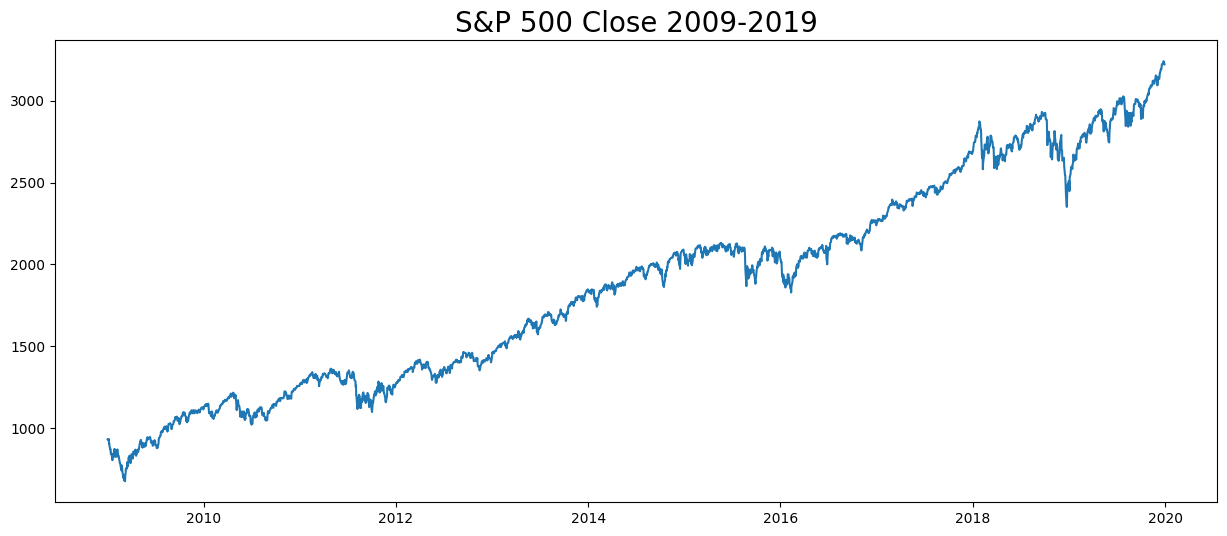

In [10]:
data = yf.download("^GSPC", start="2009-01-01", end="2019-12-31")
df = data['Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig = plt.figure(figsize=(15,6))
plt.title(f'S&P 500 Close 2009-2019', fontsize=20)
plt.plot(data.index, data['Close'] )
plt.show()

In [11]:
len(log_returns)

2766

In [12]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = s2.fit_transform(g1.fit_transform(s1.fit_transform(log_returns)))
# log_returns_rolled = rolling_window(log_returns_preprocessed, rfs)

## Tensorflow Non Causal TCN GAN (Architecture & Training)

In [ ]:
# Conv 1D, TCN with dilation, non-causal
# Architecture modified and modelled after ICashca: https://github.com/ICascha/QuantGANs-replication/blob/main/backend/tcn.py

def residual_block(prev_layer, skip_layer, kernel_size, dilation, fixed_filters, rfs, block_size, use_batchnorm, cropping):
    block = Lambda(lambda x: x)(prev_layer)

    for _ in range(block_size):
        convs = []
        prev_block= Lambda(lambda x: x)(block)
        convs.append(SpectralNormalization(Conv1D(fixed_filters, kernel_size, dilation_rate=(dilation,)))(block))
        block = convs[0]

        if use_batchnorm:
            block = BatchNormalization(axis=2, momentum=.9, epsilon=1e-5, renorm=True, renorm_momentum=.9)(block)

        block = PReLU(shared_axes=[1, 2])(block)

    drop_left = block_size * (kernel_size - 1) * dilation
    cropping += drop_left

    if skip_layer is None:
        prev_layer = Conv1D(fixed_filters, 1)(prev_layer)

    out = Add()([Cropping1D(cropping=((drop_left, 0)))(prev_layer), block])

    skip_out = Cropping1D(cropping=((rfs-1-cropping, 0)))(out)

    if skip_layer is not None:
        skip_out = Add()([skip_layer, SpectralNormalization(Conv1D(fixed_filters, 1))(skip_out)])
    else:
        skip_out = SpectralNormalization(Conv1D(fixed_filters, 1))(skip_out)

    return PReLU(shared_axes=[1, 2])(out), skip_out, cropping

def TCN(dilations, fixed_filters, use_batchnorm, input_dim, block_size=2):
    rfs = receptive_field_size(dilations, block_size)

    input_layer = Input(shape=input_dim)
    cropping = 0
    prev_layer, skip_layer, _ = residual_block(input_layer, None, 1, 1, fixed_filters, rfs, block_size, use_batchnorm, cropping)

    for dilation in dilations:
        prev_layer, skip_layer, cropping = residual_block(prev_layer, skip_layer, 2, dilation, fixed_filters, rfs, block_size, use_batchnorm, cropping)

    output_layer = PReLU(shared_axes=[1, 2])(skip_layer)
    output_layer = SpectralNormalization(Conv1D(fixed_filters, kernel_size=1))(output_layer)
    output_layer = PReLU(shared_axes=[1, 2])(output_layer)
    output_layer = SpectralNormalization(Conv1D(1, kernel_size=1))(output_layer)

    return Model(input_layer, output_layer)

def receptive_field_size(dilations, block_size):
    return block_size * sum(dilations) + 1




# Settings & Hyperparameters
dilations = 2**(np.arange(6))
n_filters = 100
rfs = 127
lr_g = 3e-5
lr_d = 1e-4
epsilon = 1e-8
beta_1 = .0
beta_2 = 0.9


discriminator = TCN(dilations, n_filters, False, [rfs, 1])
generator = TCN(dilations, n_filters, True, [None, 3])
loss = BinaryCrossentropy(from_logits=True)
generator_optimizer = Adam(lr_g, epsilon=epsilon, beta_1=beta_1, beta_2=beta_2)
discriminator_optimizer = Adam(lr_d, epsilon=epsilon, beta_1=beta_1, beta_2=beta_2)

def discriminator_loss(real_output, fake_output):
    real_loss = loss(tf.ones_like(real_output), real_output)
    fake_loss = loss(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return loss(tf.ones_like(fake_output), fake_output)


def compute_window_weights(series_length, window_size):
    # First, compute how many windows each time step appears in.
    # For a series of length T, time step i (0-indexed) appears in:
    # count[i] = min(i+1, window_size, series_length - i)
    counts = np.array([min(i + 1, window_size, series_length - i) for i in range(series_length)])

    # Now compute a weight for each possible window starting index.
    # There are (series_length - window_size + 1) windows.
    window_weights = []
    for t in range(series_length - window_size + 1):
        # For window starting at t, get the counts for all time steps in that window
        window_counts = counts[t: t + window_size]
        # The idea is to favor windows where the average count is low
        # (i.e. under-sampled time steps get higher weight)
        weight = np.mean(1.0 / window_counts)
        window_weights.append(weight)
    window_weights = np.array(window_weights)
    # Normalize weights to sum to 1
    window_weights /= window_weights.sum()
    return window_weights


def GAN(generator, discriminator, data, length, batch_size, n_batches, additional_d_steps, rfs, noise_features):
    progress = Progbar(n_batches)

    # Note that these metrics calculations are done on the preprocessed data i.e. no lambert transform
    fixed_noise = normal([128, 4000 + rfs - 1, 3])
    sq_acf_real = acf(log_returns_preprocessed**2, 250)
    real_dist = rolling_window(log_returns_preprocessed, 20, sparse = True).sum(axis=0).ravel()
    acf_scores = []
    emd_scores = []
    d_losses = []
    g_losses = []

    for n_batch in range(n_batches):
        # weighted sampling
        window_weights = compute_window_weights(length, 127)
        idx = np.random.choice(data.shape[0], batch_size)
        batch = data[idx]

        disc_loss_total = 0.0

        for _ in range(additional_d_steps + 1):
            noise = tf.random.normal([batch_size, data.shape[1]+rfs-1, noise_features])
            # print(noise.shape)
            generated_data = generator(noise, training=False)
            # print(generated_data.shape)

            with tf.GradientTape() as disc_tape:
                real_output = discriminator(batch, training=True)

                fake_output = discriminator(generated_data, training=True)
                disc_loss = discriminator_loss(real_output, fake_output)

            gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
            discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
            disc_loss_total += disc_loss

        # Average discriminator loss over the steps
        disc_loss_total /= (additional_d_steps + 1)

        # noise = tf.random.normal([batch_size, data.shape[1]+rfs-1, noise_features])
        # generated_data = generator(noise, training=False)

        noise = tf.random.normal([batch_size, data.shape[1]+rfs-1, noise_features])
        with tf.GradientTape() as gen_tape:
            generated_data = generator(noise, training=True)
            fake_output = discriminator(generated_data, training=False)
            gen_loss = generator_loss(fake_output)
            gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
            generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))


        print(f"Batch {n_batch+1}/{n_batches} - Discriminator Loss: {disc_loss:.4f}, Generator Loss: {gen_loss:.4f}")
        d_losses.append(float(np.array(disc_loss)))
        g_losses.append(float(np.array(gen_loss)))

        if (n_batch + 1) % 30 == 0:
            y = generator(fixed_noise).numpy().squeeze()
            acf_diff = np.linalg.norm(sq_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True))
            acf_scores.append(acf_diff)
            print(f"\nsq_acf_metric: {round(acf_diff, 4)}")
            fake_dist = rolling_window(y.T, 5, sparse = True).sum(axis=0).ravel()
            # print("Real dist: ", real_dist.shape)
            # print("Fake dist: ", fake_dist.shape)
            emd_diff = wasserstein_distance(real_dist, fake_dist)
            emd_scores.append(emd_diff)
            print(f"\nemd_metric: {emd_diff}")



        progress.update(n_batch + 1)

    return generator, acf_scores, emd_scores, d_losses, g_losses

data = rolling_window(log_returns_preprocessed, len(log_returns_preprocessed) - 127 + 1)
length = log_returns_preprocessed.shape[0]
batch_size = 64
n_batches = 3000
additional_d_steps = 0
noise_features = 3
trained_generator, acf_scores, emd_scores, d_losses, g_losses = GAN(generator, discriminator, data, length, batch_size, n_batches, additional_d_steps, rfs, noise_features)

Batch 1/3000 - Discriminator Loss: 1.4296, Generator Loss: 0.7047
  29/3000 [..............................] - ETA: 5:13:53Batch 30/3000 - Discriminator Loss: 1.3754, Generator Loss: 0.6445

sq_acf_metric: 1.3815

emd_metric: 4.552549060306376
  59/3000 [..............................] - ETA: 5:49:32Batch 60/3000 - Discriminator Loss: 1.3059, Generator Loss: 0.6909

sq_acf_metric: 1.2935

emd_metric: 4.141927588805327
  89/3000 [..............................] - ETA: 5:56:32Batch 90/3000 - Discriminator Loss: 1.3862, Generator Loss: 0.6946

sq_acf_metric: 1.3787

emd_metric: 1.195820652831425
 119/3000 [>.............................] - ETA: 5:56:06Batch 120/3000 - Discriminator Loss: 1.3768, Generator Loss: 0.7137

sq_acf_metric: 1.3867

emd_metric: 1.2117702920023998
 149/3000 [>.............................] - ETA: 5:58:29Batch 150/3000 - Discriminator Loss: 1.3830, Generator Loss: 0.7096

sq_acf_metric: 1.3804

emd_metric: 1.5078351483456418
 179/3000 [>............................

In [ ]:
from google.colab import files

In [ ]:
%%capture
trained_generator.save('non_causal_tcn_2019_3000')
!zip -r non_causal_tcn_2019_3000.zip non_causal_tcn_2019_3000/
# files.download('non_causal_tcn_2019_3000.zip')

In [ ]:
files.download('non_causal_tcn_2019_3000.zip')

In [ ]:
df_train_metrics = pd.DataFrame({'acf_scores': acf_scores, 'emd_scores': emd_scores})
df_train_metrics.to_csv('/content/drive/MyDrive/Thesis/QuantGAN/training_metrics.csv', index=False)  # Replace with your directory

df_train_loss = pd.DataFrame({'d_losses': d_losses, 'g_losses': g_losses})
df_train_loss.to_csv('/content/drive/MyDrive/Thesis/QuantGAN/training_loss.csv', index=False)         # Replace with your directory

In [ ]:
df_train_metrics = pd.read_csv('/content/drive/MyDrive/Thesis/QuantGAN/training_metrics.csv')  # Replace with your directory
df_train_loss = pd.read_csv('/content/drive/MyDrive/Thesis/QuantGAN/training_loss.csv')        # Replace with your directory

Text(0, 0.5, 'EMD Score')

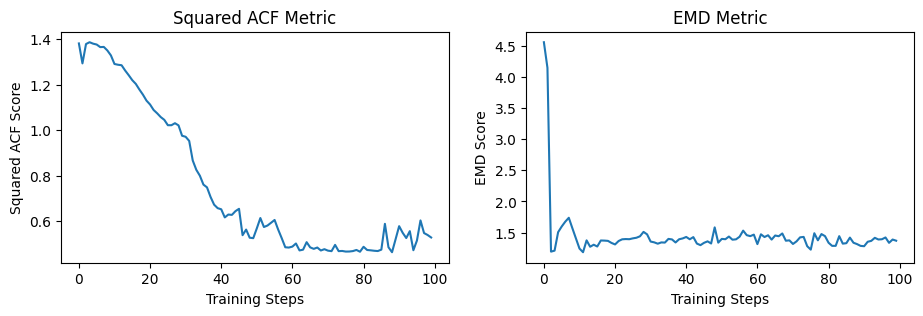

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11, 3))

axs[0].plot(df_train_metrics.index, df_train_metrics['acf_scores'])
axs[0].set_title('Squared ACF Metric')
axs[0].set_xlabel('Training Steps')
axs[0].set_ylabel('Squared ACF Score')

axs[1].plot(df_train_metrics.index, df_train_metrics['emd_scores'])
axs[1].set_title('EMD Metric')
axs[1].set_xlabel('Training Steps')
axs[1].set_ylabel('EMD Score')

Text(0.5, 1.0, 'Training Losses')

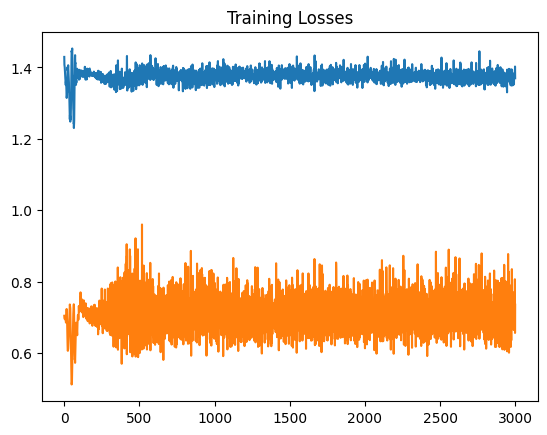

In [ ]:
plt.plot(df_train_loss.index, df_train_loss['d_losses'], label='Discriminator Loss')
plt.plot(df_train_loss.index, df_train_loss['g_losses'], label='Generator Loss')
plt.title('Training Losses')

## Stylized Facts

In [13]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Use load_model for tf version 2.12.0
generator = keras.models.load_model(
    '/content/drive/MyDrive/Thesis/QuantGAN/non_causal_tcn_2019_3000/'   # Replace with your directory
)

In [14]:
lst = []
for _ in range(10):
    noise = normal([50, len(log_returns_preprocessed) + rfs - 1, 3]) #quantgan pape uses 500 series, 4000 time steps, but we don't
    generated = generator(noise).numpy().squeeze()
    lst.append(generated)

y = np.concatenate(lst, axis=0)

y = (y - y.mean(axis=0))/y.std(axis=0)
y = s2.inverse_transform(y)
# unfortunately guassianize package doesnt support efficient column-wise transform
y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = s1.inverse_transform(y)

# some basic filtering, GAN has the tendency to produce extreme returns, caused by
# a tendency of the generator to produce heavier than normal tails, which is exercerbated
# by the lambert W transform. We filter out returns with more than twice the extremas of the
# original distribution.
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# center the log_paths for the picture
y -= y.mean()

#We retain a majority of samples
y.shape

(380, 2766)

In [15]:
y

array([[ 0.02616476,  0.01908004, -0.015617  , ...,  0.00757635,
         0.00894455,  0.0029098 ],
       [-0.00151645, -0.01788835, -0.0094034 , ..., -0.00099362,
        -0.00162938,  0.01656658],
       [ 0.00236527, -0.00177156,  0.00100165, ...,  0.00731724,
        -0.0006107 , -0.00293072],
       ...,
       [ 0.01037097, -0.01194898, -0.00922524, ..., -0.0019222 ,
        -0.00639374, -0.00168472],
       [ 0.01229442, -0.00109989,  0.0027391 , ...,  0.0019598 ,
        -0.00119513, -0.00675758],
       [ 0.00177224,  0.00021536,  0.00121213, ...,  0.00222244,
        -0.01583257, -0.00543282]], dtype=float32)

In [ ]:
# noise = normal([128, len(log_returns_preprocessed) + rfs - 1, 3])
# y = generator(noise).numpy().squeeze()

# y = (y - y.mean(axis=0))/y.std(axis=0)
# y = s2.inverse_transform(y)
# # unfortunately guassianize package doesnt support efficient column-wise transform
# y = np.array([g1.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
# y = s1.inverse_transform(y)

# # some basic filtering, GAN has the tendency to produce extreme returns, caused by
# # a tendency of the generator to produce heavier than normal tails, which is exercerbated
# # by the lambert W transform. We filter out returns with more than twice the extremas of the
# # original distribution.
# y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]

# # center the log_paths for the picture
# y -= y.mean()

# #We retain a majority of samples
# len(y)

### Distributional Metrics

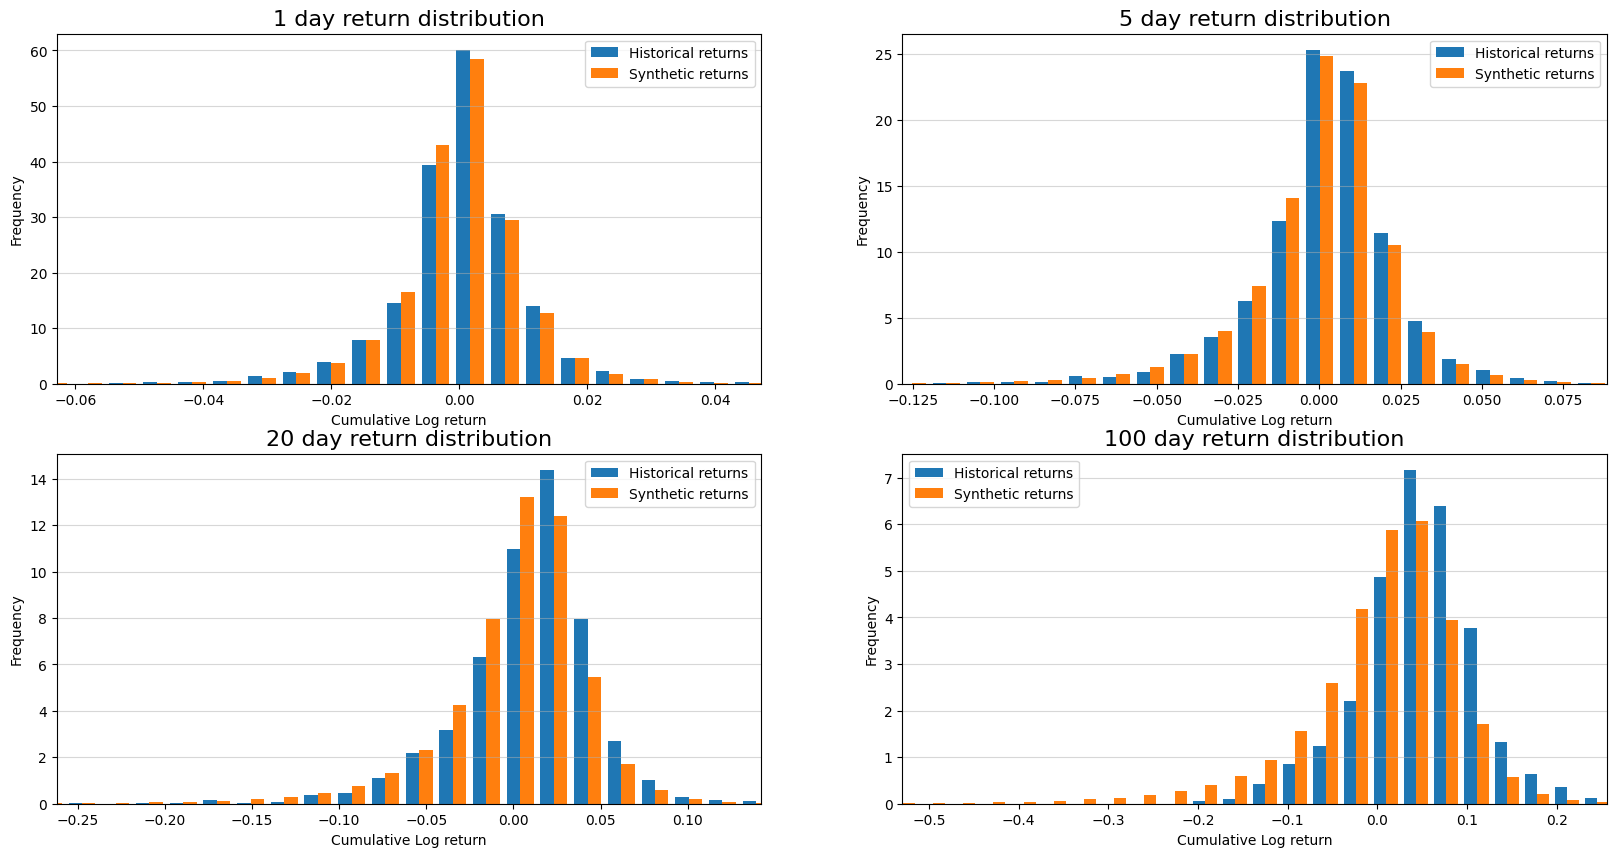

In [ ]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumulative Log return')
    axs[row,col].set_ylabel('Frequency')

    axs[row,col].legend(['Historical returns', 'Synthetic returns'])

In [ ]:
windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)
    # print(EMDscores[i])

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
df_EM

,Earth Mover Distance
window size,
1,0.000519
5,0.002284
20,0.009474
100,0.048471


### Volatility Clustering, Autocorrelation & Leverage Effect

In [ ]:
df_acf = pd.DataFrame(columns=['2 Day Volatility Score', '5 Day Volatility Score', '20 Day Volatility Score',
                               '100 Day Volatility Score', 'Vanilla ACF Score', 'Squared ACF Score',
                               'Absolute ACF Score', 'Leverage Effect Score', 'Volatility Persistence Score'])

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

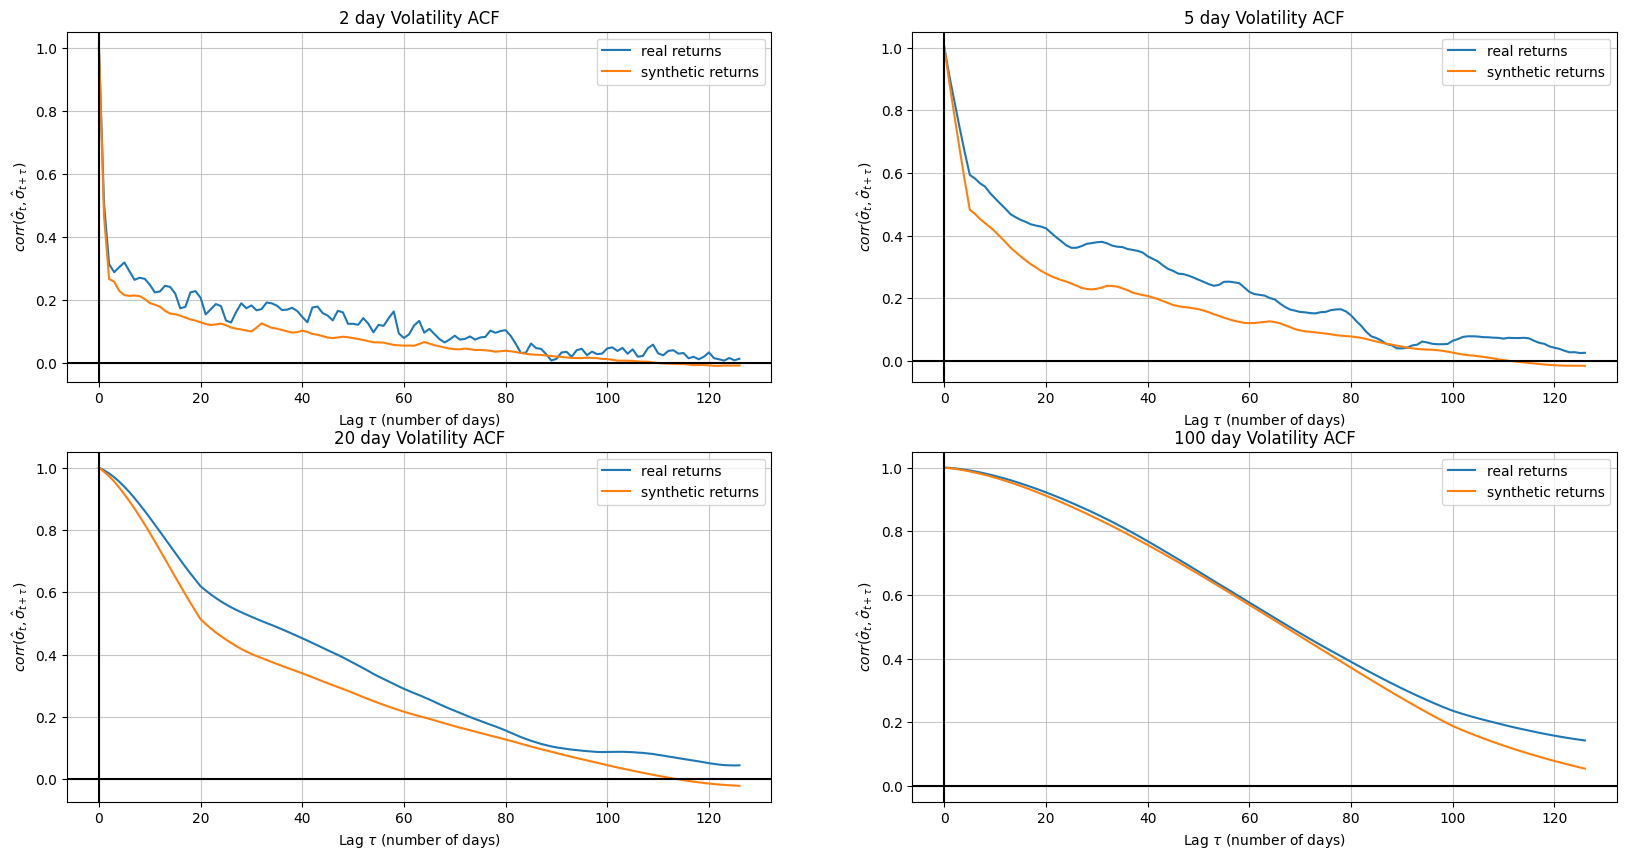

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

T = 127
vol_scores = []

# 1 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 2).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf,1)
real_acf = acf(rolling_window(log_returns, 2).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,0].grid(alpha=0.7)
axs[0,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('2 day Volatility ACF')


# 5 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 5).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 5).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,1].grid(alpha=0.7)
axs[0,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,1].set_title('5 day Volatility ACF')



# 20 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 20).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 20).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,0].grid(alpha=0.7)
axs[1,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,0].set_title('20 day Volatility ACF')


# 100 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 100).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 100).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,1].grid(alpha=0.7)
axs[1,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,1].set_title('100 day Volatility ACF')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

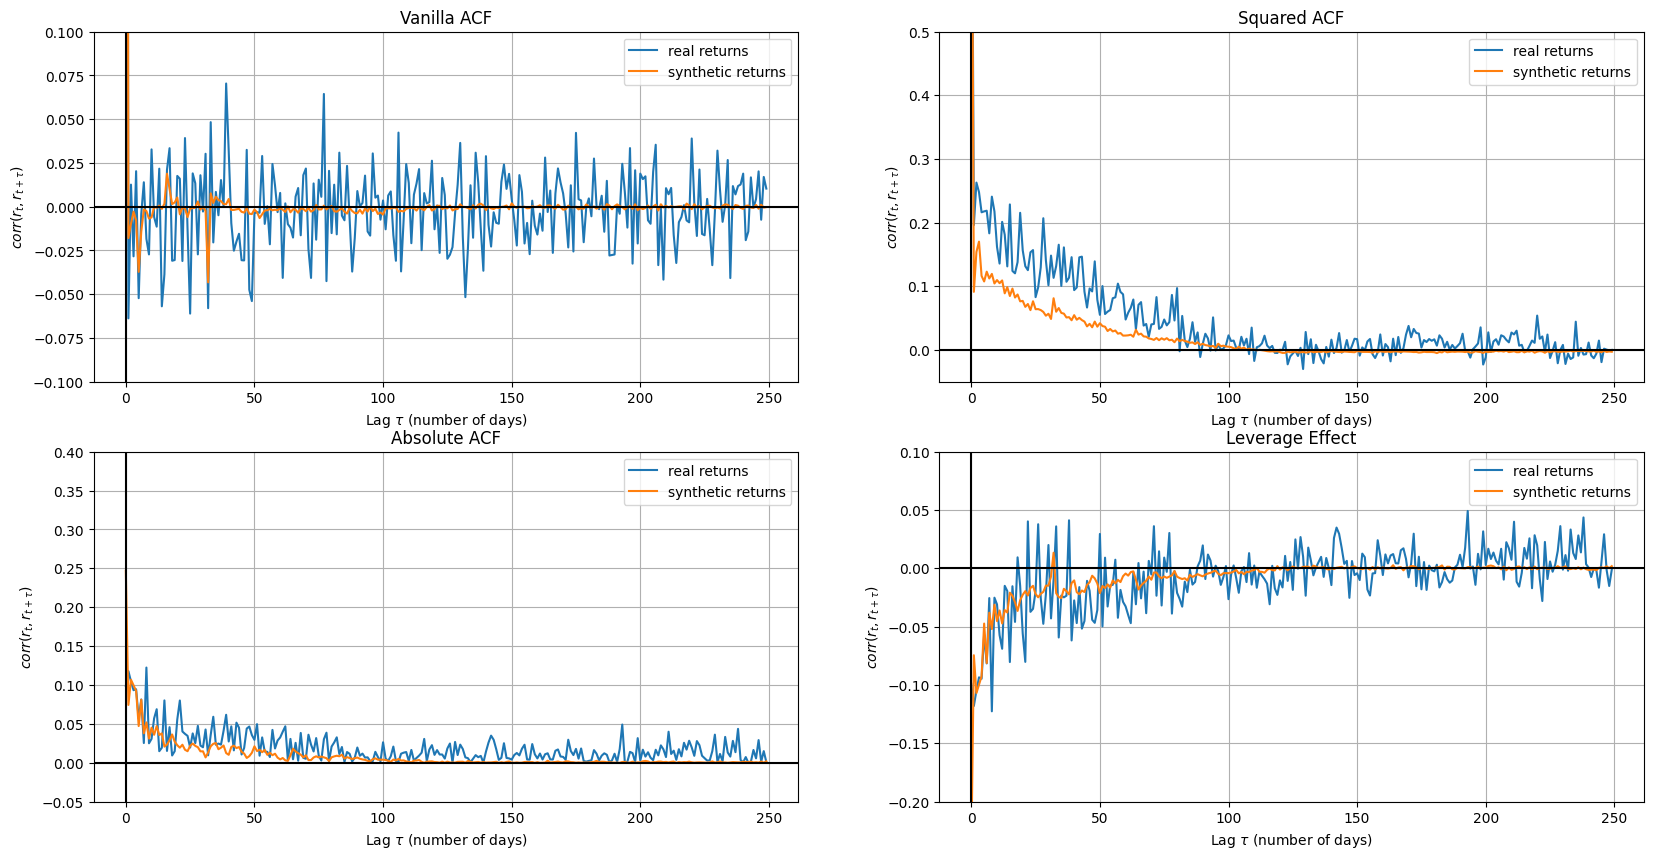

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

lags = 250
acf_scores = []

# Vanilla ACF
real_acf = acf(log_returns, lags)
fake_acf = acf(y.T, lags).mean(axis=1, keepdims=True)
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Vanilla ACF')


# Squared  ACF
real_acf = acf(log_returns**2, lags)
fake_acf = acf(y.T**2, lags).mean(axis=1, keepdims=True)
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].set_title('Squared ACF')

# Absolute  ACF
real_acf = abs(acf(log_returns, lags, le=True))
fake_acf = abs(acf(y.T, lags, le=True).mean(axis=1, keepdims=True))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute ACF')


# Leverage Effect
real_acf = acf(log_returns, lags, le=True)
fake_acf = acf(y.T, lags, le=True).mean(axis=1, keepdims=True)
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage Effect')


for ax in axs.flat:
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001131. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Real Data Parameters:
omega: 2.435204357343744e-06, alpha: 0.10116525895820278, beta: 0.878793080389131, alpha + beta: 0.9799583393473337

Synthetic Data Parameters:
omega: 2.2626282298532438e-06, alpha: 0.10000001857464125, beta: 0.8799999384856221, alpha + beta: 0.9799999570602633



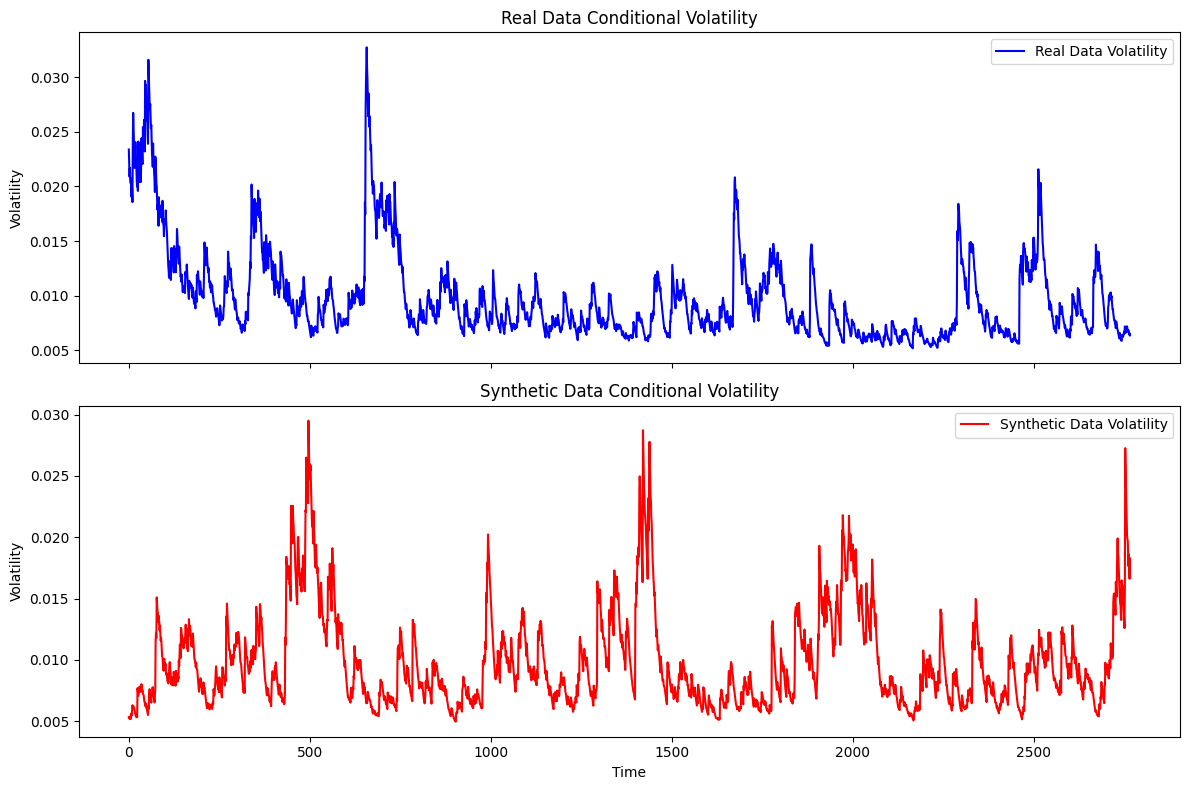

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'real_returns' and 'synthetic_returns' are your datasets as pandas Series

# Fit GARCH(1,1) model to real data
garch_real = arch_model(log_returns, vol='Garch', p=1, q=1)
res_real = garch_real.fit(disp='off')
omega_real, alpha_real, beta_real = res_real.params[['omega', 'alpha[1]', 'beta[1]']]

# Fit GARCH(1,1) model to synthetic data
garch_synth = arch_model(y[4], vol='Garch', p=1, q=1)
res_synth = garch_synth.fit(disp='off')
omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]

# Print the estimated parameters
print("Real Data Parameters:")
print(f"omega: {omega_real}, alpha: {alpha_real}, beta: {beta_real}, alpha + beta: {alpha_real + beta_real}\n")

print("Synthetic Data Parameters:")
print(f"omega: {omega_synth}, alpha: {alpha_synth}, beta: {beta_synth}, alpha + beta: {alpha_synth + beta_synth}\n")

# Plotting the conditional volatilities
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Real data volatility
axes[0].plot(res_real.conditional_volatility, color='blue', label='Real Data Volatility')
axes[0].set_title('Real Data Conditional Volatility')
axes[0].set_ylabel('Volatility')
axes[0].legend()

# Synthetic data volatility
axes[1].plot(res_synth.conditional_volatility, color='red', label='Synthetic Data Volatility')
axes[1].set_title('Synthetic Data Conditional Volatility')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Volatility')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# We call alpha + beta the volatility persistence score
alphabeta_sum = 0
for i in range(len(y)):
  garch_synth = arch_model(y[i], vol='Garch', p=1, q=1)
  res_synth = garch_synth.fit(disp='off')
  omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]
  alphabeta_sum += alpha_synth + beta_synth

In [ ]:
# # Average volatility persistence score for synthetic data
print(alphabeta_sum/len(y))

0.967872317739016


In [ ]:
all_scores = []
all_scores.extend(vol_scores)
all_scores.extend(acf_scores)
al_scores.append(alphabeta_sum/len(y))
df_acf.loc[len(df_acf)] = all_scores
df_acf

,2 Day Volatility Score,5 Day Volatility Score,20 Day Volatility Score,100 Day Volatility Score,Vanilla ACF Score,Squared ACF Score,Absolute ACF Score,Leverage Effect Score,Volatility Persistence Score
0,0.56703,1.018521,0.832563,0.401059,0.343896,0.656482,0.319635,0.359529,0.967872


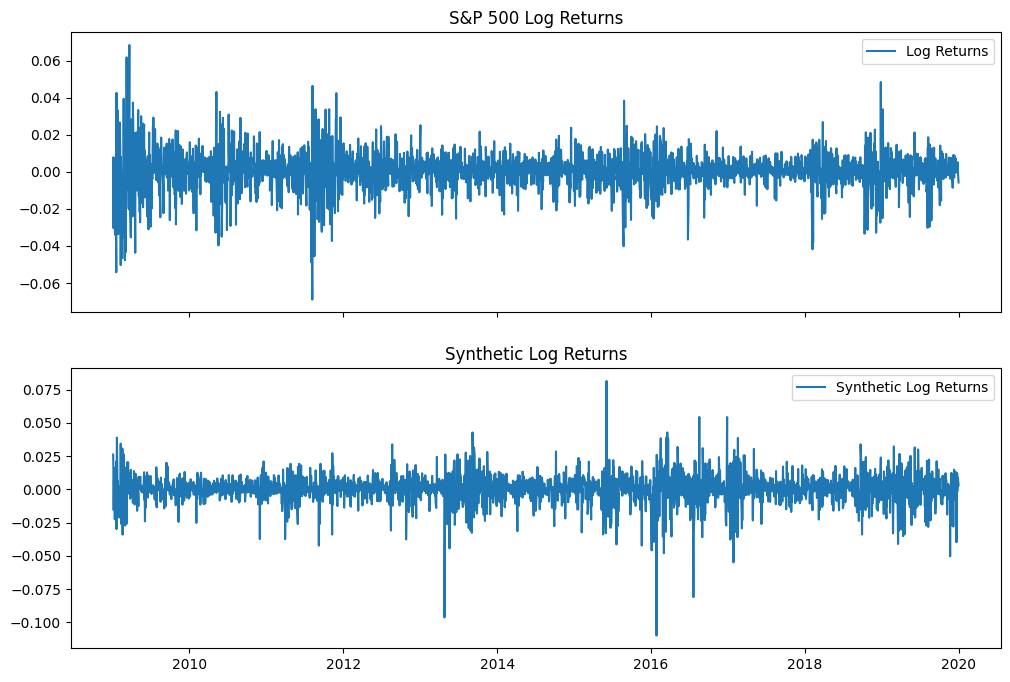

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)


axes[0].plot(data.index[1:], log_returns, label='Log Returns')
axes[0].set_title('S&P 500 Log Returns')
axes[0].legend()
axes[1].plot(data.index[1:], y[0], label='Synthetic Log Returns')
axes[1].set_title('Synthetic Log Returns')
axes[1].legend()

### Fat Tails

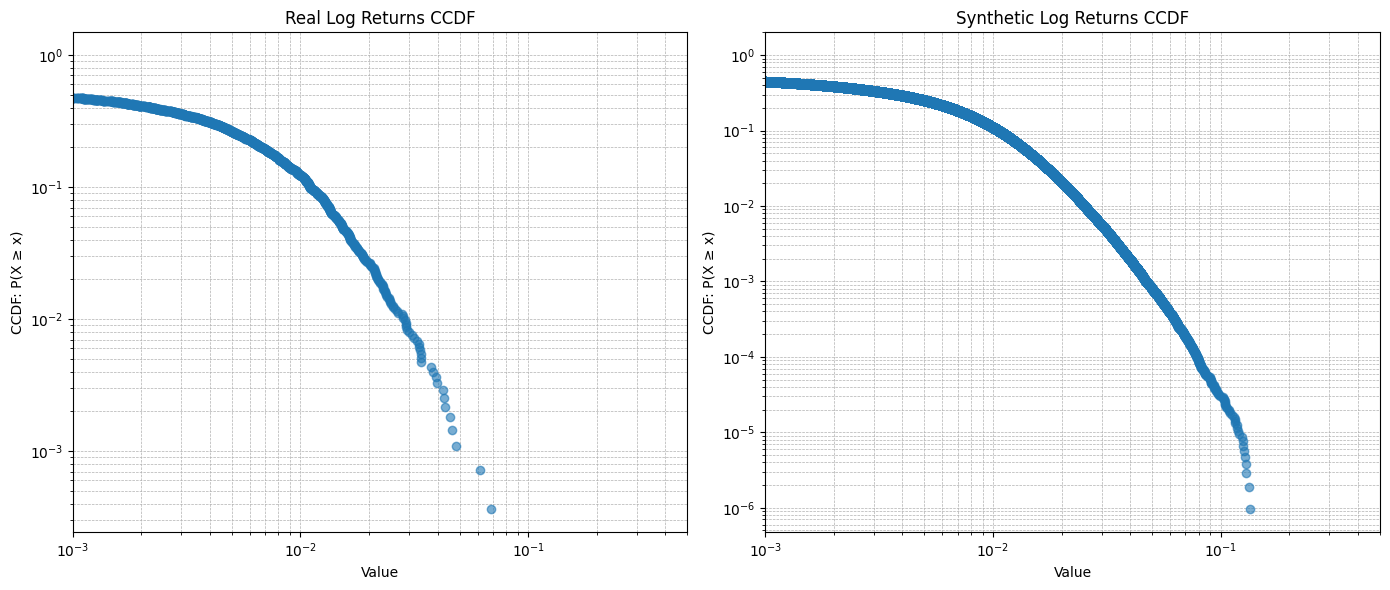

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_ccdf(data, ax, title):
    """
    Plots the CCDF (Complementary Cumulative Distribution Function) of the data on a log-log scale.

    Parameters:
        data (array-like): The data to be plotted.
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        title (str): Title of the subplot.
    """
    # Sort the data in descending order
    sorted_data = np.sort(data)[::-1]
    n = len(sorted_data)
    # Compute the CCDF: rank / total number of points
    ccdf = np.arange(1, n+1) / n

    # Plot using log-log scale
    ax.loglog(sorted_data, ccdf, marker='o', linestyle='none', alpha=0.6)
    ax.set_xlim(0.001, 0.5)
    ax.set_xlabel("Value")
    ax.set_ylabel("CCDF: P(X ≥ x)")
    ax.set_title(title)
    ax.grid(True, which='both',  ls='--', lw=0.5)

# Assume real_log_returns and synthetic_log_returns are your datasets.
# If synthetic_log_returns is 2D (e.g., 80 x 2500), we flatten it.
real_data = log_returns.flatten() if log_returns.ndim > 1 else log_returns
synthetic_data = y.flatten() if y.ndim > 1 else y

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ccdf(real_data, axes[0], "Real Log Returns CCDF")
plot_ccdf(synthetic_data, axes[1], "Synthetic Log Returns CCDF")

plt.tight_layout()
plt.show()

In [ ]:
import powerlaw
# Real data
fit = powerlaw.Fit(log_returns.flatten(), xmin=0.01)
print(fit.power_law.alpha)

# Synthetic/fake data
fit = powerlaw.Fit(y.flatten(), xmin=0.01)
print(fit.power_law.alpha)

Values less than or equal to 0 in data. Throwing out 0 or negative values


3.302494130490744
3.372463677115928


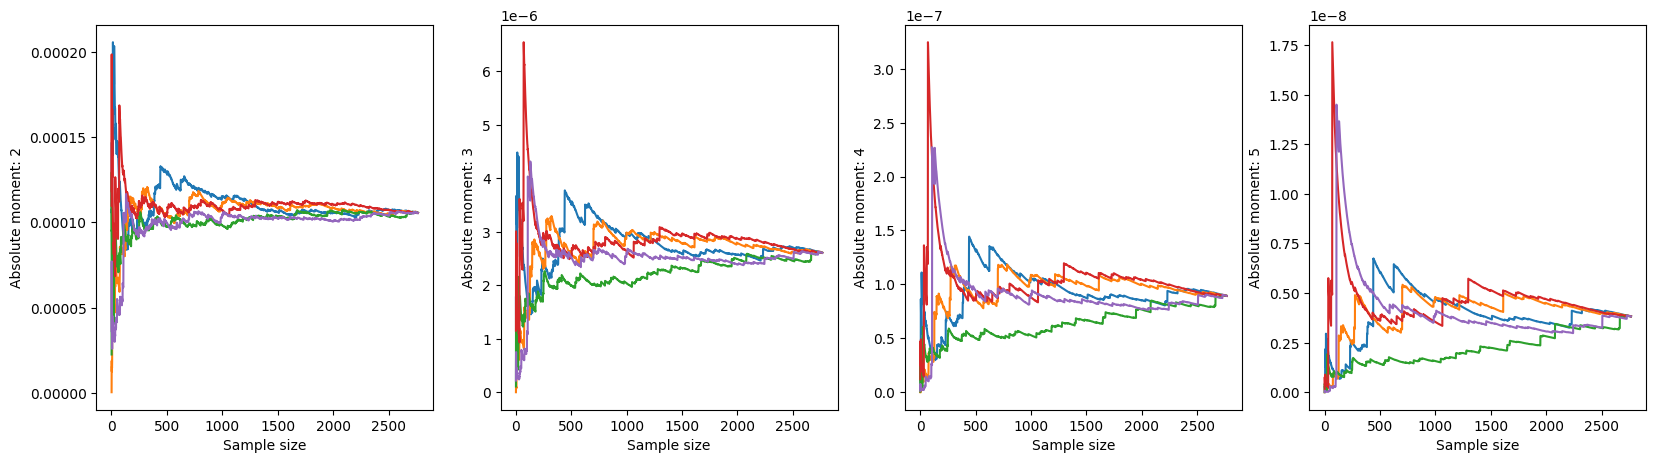

In [ ]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(log_returns))

for _ in range(5):
    shuffled_array = np.random.permutation(log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

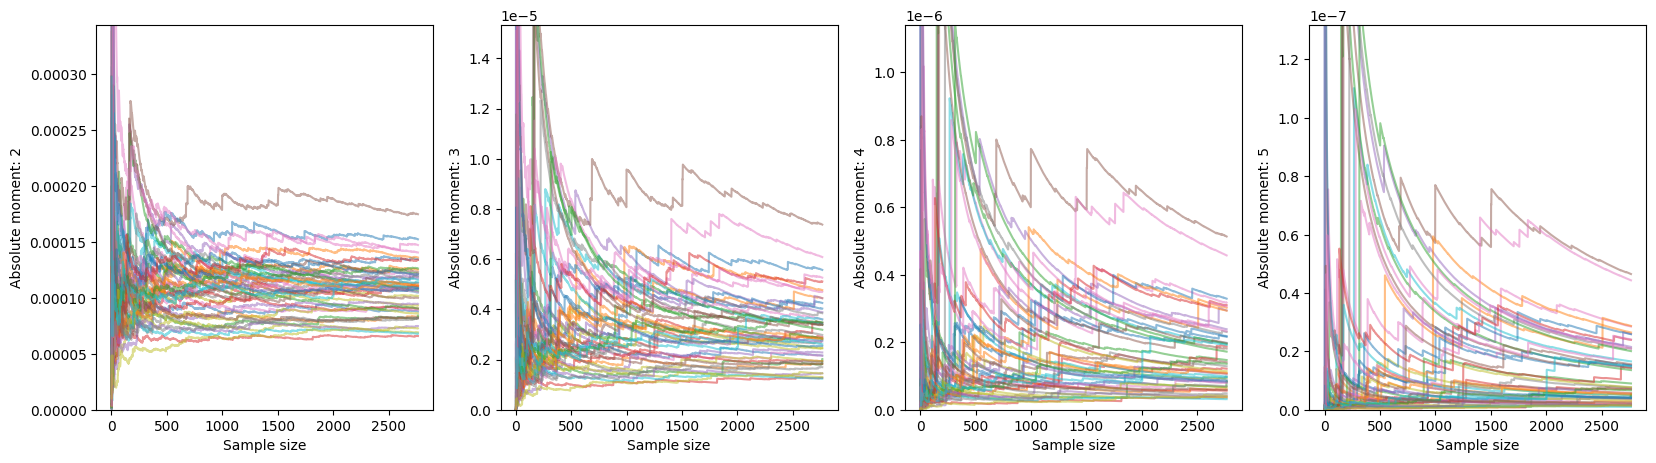

In [ ]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
# x_range = range(1, 251)
x_range = range(1, len(log_returns))

# shuffle along first index, so tranpose
shuffled_array = np.random.permutation(y.T)

for j in range(len(absolute_moments)):
    paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
    ax[j].plot(x_range, paths, alpha=0.5)
    # ax[j].set_xlim(0, 250)
    ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
    ax[j].set_xlabel('Sample size')
    ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]))